In [1]:
%%capture
!pip install pyradiomics

In [2]:
import pandas as pd
import numpy as np
import os
import pydicom
import matplotlib.pyplot as plt
import gzip
import argparse
import seaborn as sns

import SimpleITK as sitk
# from lungmask import mask
import radiomics
import cv2
import shutil
from pathlib import Path

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
import xml.etree.cElementTree as ET

from skimage.feature import graycomatrix, graycoprops
from skimage.filters import gaussian
from scipy.stats import moment

import torch
import torchvision.models as models
import torchvision.transforms as transforms

In [3]:
clinical_data = pd.read_csv("/kaggle/input/mydataset/NSCLCR01Radiogenomic_DATA_LABELS_2018-05-22_1500-shifted.csv")
clinical_data

,Case ID,Patient affiliation,Age at Histological Diagnosis,Weight (lbs),Gender,Ethnicity,Smoking status,Pack Years,Quit Smoking Year,%GG,...,Recurrence,Recurrence Location,Date of Recurrence,Date of Last Known Alive,Survival Status,Date of Death,Time to Death (days),CT Date,Days between CT and surgery,PET Date
0,AMC-001,Stanford,34,Not Collected,Male,Not Recorded In Database,Nonsmoker,NaN,NaN,Not Assessed,...,yes,distant,10/7/1994,1/7/1997,Dead,1/7/1997,872.0,8/10/1994,9,Not Collected
1,AMC-002,Stanford,33,Not Collected,Female,Not Recorded In Database,Nonsmoker,NaN,NaN,Not Assessed,...,no,NaN,NaN,3/20/1992,Alive,NaN,NaN,2/19/1992,3,Not Collected
2,AMC-003,Stanford,69,Not Collected,Female,Not Recorded In Database,Nonsmoker,NaN,NaN,Not Assessed,...,no,NaN,NaN,6/19/1996,Alive,NaN,NaN,2/23/1995,28,Not Collected
3,AMC-004,Stanford,80,Not Collected,Female,Not Recorded In Database,Nonsmoker,NaN,NaN,Not Assessed,...,no,NaN,NaN,12/13/1996,Alive,NaN,NaN,12/26/1992,47,Not Collected
4,AMC-005,Stanford,76,Not Collected,Male,Not Recorded In Database,Former,30,1962.0,Not Assessed,...,yes,distant,1/4/1996,1/7/1997,Alive,NaN,NaN,7/21/1994,2,Not Collected
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,R01-159,Stanford,75,184,Male,Caucasian,Former,55,1994.0,Not Assessed,...,no,NaN,NaN,7/13/1995,Alive,NaN,NaN,11/24/1994,14,11/16/1994
207,R01-160,VA,61,231.5,Male,Caucasian,Former,12,1993.0,Not Assessed,...,no,NaN,NaN,7/3/1999,Alive,NaN,NaN,8/12/1993,72,9/22/1993
208,R01-161,Stanford,52,Not Collected,Female,Caucasian,Former,7,NaN,Not Assessed,...,no,NaN,NaN,4/2/1999,Alive,NaN,NaN,12/13/1995,8,9/26/1995
209,R01-162,Stanford,67,158,Male,Asian,Former,15,1966.0,Not Assessed,...,no,NaN,NaN,10/8/1997,Dead,10/8/1997,671.0,10/3/1995,65,11/14/1995


In [4]:
patient_meta = pd.read_csv("/kaggle/input/mydataset/manifest-1622561851074/manifest-1622561851074/metadata.csv")
patient_meta

,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp
0,1.3.6.1.4.1.14519.5.2.1.4334.1501.104663944588...,NSCLC Radiogenomics,NaN,https://doi.org/10.7937/K9/TCIA.2017.7hs46erv,AMC-001,1.3.6.1.4.1.14519.5.2.1.4334.1501.227933499470...,PETCT Lung Cancer,04-30-1994,SCOUT,GE MEDICAL SYSTEMS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,1,3.91 MB,./NSCLC Radiogenomics/AMC-001/04-30-1994-NA-PE...,2023-07-02T23:23:47.318
1,1.3.6.1.4.1.14519.5.2.1.4334.1501.172353892710...,NSCLC Radiogenomics,NaN,https://doi.org/10.7937/K9/TCIA.2017.7hs46erv,AMC-001,1.3.6.1.4.1.14519.5.2.1.4334.1501.227933499470...,PETCT Lung Cancer,04-30-1994,WB NAC P690,GE MEDICAL SYSTEMS,PT,Positron Emission Tomography Image Storage,1.2.840.10008.5.1.4.1.1.128,263,20.38 MB,./NSCLC Radiogenomics/AMC-001/04-30-1994-NA-PE...,2023-07-02T23:23:50.948
2,1.3.6.1.4.1.14519.5.2.1.4334.1501.680033973739...,NSCLC Radiogenomics,NaN,https://doi.org/10.7937/K9/TCIA.2017.7hs46erv,AMC-001,1.3.6.1.4.1.14519.5.2.1.4334.1501.227933499470...,PETCT Lung Cancer,04-30-1994,WB MAC P690,GE MEDICAL SYSTEMS,PT,Positron Emission Tomography Image Storage,1.2.840.10008.5.1.4.1.1.128,263,20.39 MB,./NSCLC Radiogenomics/AMC-001/04-30-1994-NA-PE...,2023-07-02T23:23:54.446
3,1.3.6.1.4.1.14519.5.2.1.4334.1501.131836349235...,NSCLC Radiogenomics,NaN,https://doi.org/10.7937/K9/TCIA.2017.7hs46erv,AMC-001,1.3.6.1.4.1.14519.5.2.1.4334.1501.227933499470...,PETCT Lung Cancer,04-30-1994,CT FUSION,GE MEDICAL SYSTEMS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,263,138.68 MB,./NSCLC Radiogenomics/AMC-001/04-30-1994-NA-PE...,2023-07-02T23:24:45.895
4,1.3.6.1.4.1.14519.5.2.1.4334.1501.128241934543...,NSCLC Radiogenomics,NaN,https://doi.org/10.7937/K9/TCIA.2017.7hs46erv,AMC-001,1.3.6.1.4.1.14519.5.2.1.4334.1501.772823147212...,CT Thorax,08-10-1994,CHEST 1.25 MM SHARP,GE MEDICAL SYSTEMS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,253,133.40 MB,./NSCLC Radiogenomics/AMC-001/08-10-1994-NA-CT...,2023-07-02T23:24:51.979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1346,1.3.6.1.4.1.14519.5.2.1.4334.1501.238304204206...,NSCLC Radiogenomics,NaN,https://doi.org/10.7937/K9/TCIA.2017.7hs46erv,AMC-012,1.3.6.1.4.1.14519.5.2.1.4334.1501.137979220896...,CT CHEST REFERENCE ONLY,11-10-1993,coronals,Philips,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,143,68.95 MB,./NSCLC Radiogenomics/AMC-012/11-10-1993-NA-CT...,2023-07-03T09:50:42.001
1347,1.3.6.1.4.1.14519.5.2.1.4334.1501.256599181343...,NSCLC Radiogenomics,NaN,https://doi.org/10.7937/K9/TCIA.2017.7hs46erv,R01-026,1.3.6.1.4.1.14519.5.2.1.4334.1501.655577627062...,CT CHEST ABD PELVIS WITH CON,11-12-1990,Recon 2 CAP,NaN,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,376,198.09 MB,./NSCLC Radiogenomics/R01-026/11-12-1990-NA-CT...,2023-07-03T09:50:49.601
1348,1.3.6.1.4.1.14519.5.2.1.4334.1501.277919130943...,NSCLC Radiogenomics,NaN,https://doi.org/10.7937/K9/TCIA.2017.7hs46erv,R01-072,1.3.6.1.4.1.14519.5.2.1.4334.1501.897620958899...,PETCT LUNG SPN,02-03-1994,CTSLICES,GE MEDICAL SYSTEMS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,257,135.54 MB,./NSCLC Radiogenomics/R01-072/02-03-1994-NA-PE...,2023-07-03T09:50:55.068
1349,1.3.6.1.4.1.14519.5.2.1.4334.1501.444046764030...,NSCLC Radiogenomics,NaN,https://doi.org/10.7937/K9/TCIA.2017.7hs46erv,R01-072,1.3.6.1.4.1.14519.5.2.1.4334.1501.897620958899...,PETCT LUNG SPN,02-03-1994,SAG CT,GE MEDICAL SYSTEMS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,413,217.69 MB,./NSCLC Radiogenomics/R01-072/02-03-1994-NA-PE...,2023-07-03T09:51:08.006


In [5]:
gene_data = pd.read_csv("/kaggle/input/nsclc-gene-data/GSE103584_R01_NSCLC_RNAseq.txt", sep='\t', index_col=0)
gene_data = gene_data.T

In [6]:
gene_data

,1/2-SBSRNA4,A1BG,A1BG-AS1,A1CF,A2LD1,A2M,A2ML1,A2MP1,A4GALT,A4GNT,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,tAKR
R01-023,NaN,NaN,NaN,NaN,2.034380,59.5255,NaN,NaN,2.475232,NaN,...,NaN,2.647025,0.987489,12.505150,NaN,3.472997,11.285434,9.602287,60.781455,NaN
R01-024,NaN,2.528510,NaN,NaN,0.436761,31.7306,2.374324,NaN,2.588888,NaN,...,3.595700,0.820777,1.117200,12.965631,NaN,5.126819,10.920210,5.065447,50.243009,2.237496
R01-006,NaN,1.713994,NaN,NaN,1.601030,40.8846,0.477936,NaN,1.908870,NaN,...,1.715370,4.313210,1.908360,16.919100,NaN,5.544750,5.967490,5.518227,77.056216,NaN
R01-153,NaN,3.143938,0.646213,NaN,3.366031,93.2069,NaN,NaN,1.479920,NaN,...,5.426810,2.305033,1.826140,17.253040,NaN,3.876170,26.631100,12.130147,77.235453,NaN
R01-031,NaN,1.795080,NaN,NaN,0.994382,27.9210,NaN,NaN,1.828780,NaN,...,3.543730,0.977787,2.264630,14.226541,NaN,7.175560,14.111400,11.410494,81.196830,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R01-141,NaN,2.094170,1.304690,NaN,NaN,142.1040,NaN,NaN,2.711100,NaN,...,6.356400,1.627650,1.543680,16.328380,NaN,94.510210,8.754060,9.005920,68.392210,NaN
R01-142,NaN,1.944550,1.055700,NaN,NaN,233.7730,NaN,1.622167,2.869876,NaN,...,NaN,1.874630,3.660330,6.604060,NaN,62.094580,21.238980,7.571560,71.528003,NaN
R01-144,NaN,NaN,0.939564,NaN,NaN,153.0460,NaN,NaN,1.163060,NaN,...,1.646760,2.613970,4.277221,12.545441,NaN,79.505468,12.383909,2.859420,50.273287,NaN
R01-145,NaN,6.130287,1.445220,NaN,NaN,192.5240,NaN,0.340432,3.440720,NaN,...,3.500085,1.745628,1.423690,5.496585,1.05644,71.244270,24.413600,8.594376,55.254989,NaN


In [7]:
cols_no_na = gene_data.columns[gene_data.notna().all()].tolist()
len(cols_no_na)

5268

In [8]:
gene_data_2 = gene_data[cols_no_na]
gene_data_2

,A2M,AAAS,AAGAB,AAK1,AAMP,AARS,AARS2,AASDHPPT,AASS,AATF,...,ZRANB1,ZRANB2,ZSCAN29,ZSWIM6,ZW10,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
R01-023,59.5255,2.50285,10.290372,37.422410,6.29851,5.73343,3.296422,8.382984,17.524260,7.53224,...,10.458520,9.054210,5.890151,109.721298,3.868957,12.505150,3.472997,11.285434,9.602287,60.781455
R01-024,31.7306,5.33951,8.559640,27.581091,9.58367,8.63052,3.973313,6.456990,30.628670,3.69044,...,11.756743,32.928890,4.386016,97.095292,3.105326,12.965631,5.126819,10.920210,5.065447,50.243009
R01-006,40.8846,3.94623,4.441260,4.954714,18.37820,6.47787,5.749020,10.257800,5.608410,10.41149,...,7.369230,32.393370,2.680360,124.651458,3.791700,16.919100,5.544750,5.967490,5.518227,77.056216
R01-153,93.2069,5.20715,9.368470,21.177466,14.05770,15.07900,6.788850,6.610790,1.520820,13.79060,...,6.329274,27.751362,2.561210,106.489793,3.105460,17.253040,3.876170,26.631100,12.130147,77.235453
R01-031,27.9210,4.99749,4.062710,29.294510,24.44340,11.12274,6.123681,4.838392,4.518720,8.80233,...,12.432172,22.702390,4.659510,90.552955,2.253310,14.226541,7.175560,14.111400,11.410494,81.196830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R01-141,142.1040,5.72954,18.863984,21.800506,7.11663,7.02312,7.536990,21.063690,7.619757,20.08725,...,20.304580,9.653680,5.486282,92.388061,7.591711,16.328380,94.510210,8.754060,9.005920,68.392210
R01-142,233.7730,4.61238,12.568738,43.362620,11.01600,10.55034,11.644539,9.369357,19.404920,7.17934,...,19.352600,9.856360,3.026241,86.868956,2.960870,6.604060,62.094580,21.238980,7.571560,71.528003
R01-144,153.0460,4.75882,10.989190,21.224142,13.97000,6.33268,9.515370,12.280170,19.552779,12.40630,...,11.347985,14.111240,3.129860,290.975960,4.266538,12.545441,79.505468,12.383909,2.859420,50.273287
R01-145,192.5240,4.58766,10.269001,43.426958,10.95920,12.87330,7.736255,13.525000,7.886477,7.94311,...,12.632469,12.179900,2.114120,98.947163,3.373990,5.496585,71.244270,24.413600,8.594376,55.254989


In [9]:
gene_data_2 = gene_data_2.apply(lambda x: (x - np.mean(x)) / np.std(x), axis=1)
gene_data_2

,A2M,AAAS,AAGAB,AAK1,AAMP,AARS,AARS2,AASDHPPT,AASS,AATF,...,ZRANB1,ZRANB2,ZSCAN29,ZSWIM6,ZW10,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
R01-023,-0.017386,-0.017635,-0.017601,-0.017482,-0.017619,-0.017621,-0.017632,-0.017610,-0.017570,-0.017613,...,-0.017600,-0.017607,-0.017621,-0.017166,-0.017629,-0.017592,-0.017631,-0.017597,-0.017604,-0.017380
R01-024,-0.025881,-0.025910,-0.025907,-0.025886,-0.025906,-0.025907,-0.025912,-0.025909,-0.025883,-0.025912,...,-0.025903,-0.025880,-0.025911,-0.025810,-0.025913,-0.025902,-0.025911,-0.025904,-0.025911,-0.025861
R01-006,-0.013824,-0.013981,-0.013979,-0.013977,-0.013920,-0.013971,-0.013974,-0.013954,-0.013974,-0.013954,...,-0.013967,-0.013861,-0.013987,-0.013469,-0.013982,-0.013926,-0.013975,-0.013973,-0.013975,-0.013671
R01-153,-0.017210,-0.017327,-0.017321,-0.017306,-0.017315,-0.017314,-0.017325,-0.017325,-0.017332,-0.017315,...,-0.017325,-0.017297,-0.017330,-0.017192,-0.017330,-0.017311,-0.017329,-0.017298,-0.017318,-0.017231
R01-031,-0.016001,-0.016002,-0.016002,-0.016001,-0.016001,-0.016002,-0.016002,-0.016002,-0.016002,-0.016002,...,-0.016001,-0.016001,-0.016002,-0.015997,-0.016002,-0.016001,-0.016002,-0.016001,-0.016002,-0.015998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R01-141,0.312040,-0.101322,-0.061510,-0.052609,-0.097117,-0.097401,-0.095843,-0.054843,-0.095592,-0.057802,...,-0.057143,-0.089427,-0.102059,0.161347,-0.095677,-0.069196,0.167780,-0.092154,-0.091391,0.088614
R01-142,0.657831,-0.104318,-0.077856,0.024559,-0.083021,-0.084569,-0.080930,-0.088497,-0.055120,-0.095781,...,-0.055294,-0.086877,-0.109593,0.169254,-0.109811,-0.097694,0.086858,-0.049021,-0.094476,0.118232
R01-144,0.270646,-0.101462,-0.085828,-0.060144,-0.078348,-0.097513,-0.089526,-0.082588,-0.064338,-0.082272,...,-0.084927,-0.077993,-0.105550,0.616764,-0.102697,-0.081922,0.086105,-0.082328,-0.106228,0.012751
R01-145,0.315309,-0.075136,-0.063332,0.005555,-0.061898,-0.057922,-0.068594,-0.056568,-0.068282,-0.068164,...,-0.058422,-0.059362,-0.080274,0.120900,-0.077657,-0.073247,0.063346,-0.033946,-0.066811,0.030128


In [10]:
gene_data_2.reset_index(inplace=True)
gene_data_2.rename(columns={'index':'Case ID'},inplace=True)

In [11]:
merged_gene_data_2 = pd.merge(gene_data_2,clinical_data[['Case ID','Recurrence']],on='Case ID',how='left')
rec_mapping = {'yes':1,'no':0}
merged_gene_data_2['Recurrence'] = merged_gene_data_2['Recurrence'].map(rec_mapping)

In [12]:
merged_gene_data_2

,Case ID,A2M,AAAS,AAGAB,AAK1,AAMP,AARS,AARS2,AASDHPPT,AASS,...,ZRANB2,ZSCAN29,ZSWIM6,ZW10,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3,Recurrence
0,R01-023,-0.017386,-0.017635,-0.017601,-0.017482,-0.017619,-0.017621,-0.017632,-0.017610,-0.017570,...,-0.017607,-0.017621,-0.017166,-0.017629,-0.017592,-0.017631,-0.017597,-0.017604,-0.017380,0
1,R01-024,-0.025881,-0.025910,-0.025907,-0.025886,-0.025906,-0.025907,-0.025912,-0.025909,-0.025883,...,-0.025880,-0.025911,-0.025810,-0.025913,-0.025902,-0.025911,-0.025904,-0.025911,-0.025861,1
2,R01-006,-0.013824,-0.013981,-0.013979,-0.013977,-0.013920,-0.013971,-0.013974,-0.013954,-0.013974,...,-0.013861,-0.013987,-0.013469,-0.013982,-0.013926,-0.013975,-0.013973,-0.013975,-0.013671,0
3,R01-153,-0.017210,-0.017327,-0.017321,-0.017306,-0.017315,-0.017314,-0.017325,-0.017325,-0.017332,...,-0.017297,-0.017330,-0.017192,-0.017330,-0.017311,-0.017329,-0.017298,-0.017318,-0.017231,1
4,R01-031,-0.016001,-0.016002,-0.016002,-0.016001,-0.016001,-0.016002,-0.016002,-0.016002,-0.016002,...,-0.016001,-0.016002,-0.015997,-0.016002,-0.016001,-0.016002,-0.016001,-0.016002,-0.015998,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,R01-141,0.312040,-0.101322,-0.061510,-0.052609,-0.097117,-0.097401,-0.095843,-0.054843,-0.095592,...,-0.089427,-0.102059,0.161347,-0.095677,-0.069196,0.167780,-0.092154,-0.091391,0.088614,1
126,R01-142,0.657831,-0.104318,-0.077856,0.024559,-0.083021,-0.084569,-0.080930,-0.088497,-0.055120,...,-0.086877,-0.109593,0.169254,-0.109811,-0.097694,0.086858,-0.049021,-0.094476,0.118232,0
127,R01-144,0.270646,-0.101462,-0.085828,-0.060144,-0.078348,-0.097513,-0.089526,-0.082588,-0.064338,...,-0.077993,-0.105550,0.616764,-0.102697,-0.081922,0.086105,-0.082328,-0.106228,0.012751,0
128,R01-145,0.315309,-0.075136,-0.063332,0.005555,-0.061898,-0.057922,-0.068594,-0.056568,-0.068282,...,-0.059362,-0.080274,0.120900,-0.077657,-0.073247,0.063346,-0.033946,-0.066811,0.030128,0


In [13]:
def load_tumor_mask(mask_path):
    seg_reader = sitk.ImageSeriesReader()
    seg_dicom_names = seg_reader.GetGDCMSeriesFileNames(mask_path)
    seg_reader.SetFileNames(seg_dicom_names)
    seg_image = seg_reader.Execute()

    seg_image_array = sitk.GetArrayFromImage(seg_image)
    seg_image_array = seg_image_array.squeeze(0)
    return seg_image_array

def load_ct_image(img_path):
    ct_reader = sitk.ImageSeriesReader()
    ct_dicom_names = ct_reader.GetGDCMSeriesFileNames(img_path)
    ct_reader.SetFileNames(ct_dicom_names)
    ct_image = ct_reader.Execute()
    ct_image_array = sitk.GetArrayFromImage(ct_image)
    return ct_image_array

def load_ct_slice(dcm_path):
    dicom_image = sitk.ReadImage(dcm_path)
    image_array = sitk.GetArrayFromImage(dicom_image)
    return image_array

def slices(mask_path):
    tumor_mask = load_tumor_mask(mask_path)
    largest_slice_index = np.argmax(np.sum(tumor_mask,axis=(1,2)))
    selected_slice_indices = [largest_slice_index-1,largest_slice_index,largest_slice_index+1]
    return selected_slice_indices

def save_images(img_path,id,seg_path):
    paths=[]
    folder_path = Path(f'/kaggle/working/{id}')
    folder_path.mkdir(parents=True, exist_ok=True)
    selected_slices = slices(seg_path)
    seg_image_array = load_tumor_mask(seg_path)
    ct_image_array = load_ct_image(img_path)
    
    for slice in selected_slices:
        ct_index = int((slice / seg_image_array.shape[0]) * ct_image_array.shape[0])
        if int(ct_index)<10:
            ct_index = "1-00"+str(ct_index)+".dcm"
        elif int(ct_index)<100 and int(ct_index)>9:
            ct_index = "1-0"+str(ct_index)+".dcm"
        else:
            ct_index = "1-"+str(ct_index)+".dcm"
        path = os.path.join(img_path,ct_index)
        paths.append(path)
        with open(f'/kaggle/working/{id}/image_paths.txt', 'w') as f:
            for path in paths:
                f.write("%s\n" % path)        
    with open(f'/kaggle/working/{id}/seg_path.txt', 'w') as f:
        f.write("%s\n" % seg_path)       

def Image(img_path):
    ct_reader = sitk.ImageSeriesReader()
    ct_dicom_names = ct_reader.GetGDCMSeriesFileNames(img_path)
    ct_reader.SetFileNames(ct_dicom_names)
    ct_image = ct_reader.Execute()
    return ct_image

def croppedImages(seg_slices,seg_path,ct_slice_paths):
    seg_array = load_tumor_mask(seg_path)
    cropped_images = []
    for i in range(len(seg_slices)):
        ct_slice_path = ct_slice_paths[i]
        ct_image_array = load_ct_slice(ct_slice_path)
        ct_image_array = ct_image_array.squeeze(0)
        seg_slice = seg_array[seg_slices[i]]
        bounding_box = get_bounding_box(seg_slice)
        cropped_slice_array = extract_roi(ct_image_array, bounding_box)
        cropped_slice_array = np.clip(cropped_slice_array, -1000, 400)
        cropped_slice_array = ((cropped_slice_array - (-1000)) / (400 - (-1000))) * 255
        resized_slice = cv2.resize(cropped_slice_array.astype(np.uint8),(224,224))
        cropped_images.append(resized_slice)
        
    stacked_image = np.stack([cropped_images[0],cropped_images[1],cropped_images[2]],axis=2) 
    
    return cropped_images,stacked_image 

def get_bounding_box(segmentation_array):
    nonzero_indices = np.nonzero(segmentation_array)

    min_x = np.min(nonzero_indices[0])
    max_x = np.max(nonzero_indices[0])
    min_y = np.min(nonzero_indices[1])
    max_y = np.max(nonzero_indices[1])

    return [min_x, max_x, min_y, max_y]

def plot_bounding_box(ct_image_array,bounding_box):
    x1 = bounding_box[2]
    x2 = bounding_box[3]
    y1 = bounding_box[0]
    y2 = bounding_box[1]

    plt.imshow(ct_image_array, cmap='gray')

    plt.plot([x1, x2], [y1, y1], color='red', linestyle='-', linewidth=2)  # Top line
    plt.plot([x1, x2], [y2, y2], color='red', linestyle='-', linewidth=2)  # Bottom line
    plt.plot([x1, x1], [y1, y2], color='red', linestyle='-', linewidth=2)  # Left line
    plt.plot([x2, x2], [y1, y2], color='red', linestyle='-', linewidth=2)  # Right line
    plt.show()
    
def extract_roi(ct_image_array, bounding_box):
    min_x, max_x, min_y, max_y = bounding_box
    roi = ct_image_array[min_x:max_x+1, min_y:max_y+1]
    return roi

def plot_roi(roi):
    plt.imshow(roi, cmap='gray')
    plt.axis('off')
    plt.show()

In [14]:
slices("/kaggle/input/mydataset/manifest-1622561851074/manifest-1622561851074/NSCLC Radiogenomics/R01-023/04-20-1991-NA-CT ANGIOGRAPHY CHEST-37940/1000.000000-3D Slicer segmentation result-39719")

[32, 33, 34]

Text(0.5, 1.0, 'CT Image')

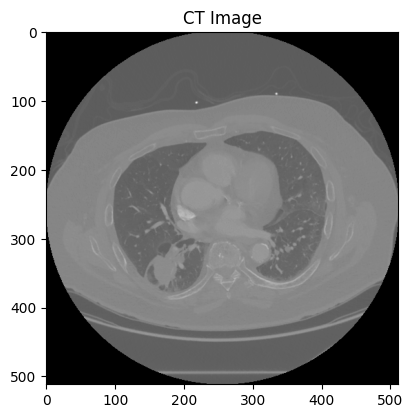

In [15]:
ct_reader = sitk.ImageSeriesReader()
ct_dicom_names = ct_reader.GetGDCMSeriesFileNames("/kaggle/input/mydataset/manifest-1622561851074/manifest-1622561851074/NSCLC Radiogenomics/R01-023/04-20-1991-NA-CT ANGIOGRAPHY CHEST-37940/2.000000-0.625  DMPR On  SS50-86093")
ct_reader.SetFileNames(ct_dicom_names)
ct_image = ct_reader.Execute()

ct_image_array = sitk.GetArrayFromImage(ct_image)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(ct_image_array[ct_image_array.shape[0]//2,:,:], cmap='gray')
plt.title("CT Image")

In [16]:
ct_image_array.shape

(483, 512, 512)

Text(0.5, 1.0, 'Seg Image')

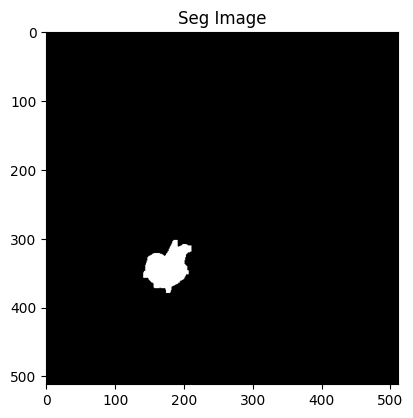

In [17]:
seg_reader = sitk.ImageSeriesReader()
seg_dicom_names = seg_reader.GetGDCMSeriesFileNames("/kaggle/input/mydataset/manifest-1622561851074/manifest-1622561851074/NSCLC Radiogenomics/R01-023/04-20-1991-NA-CT ANGIOGRAPHY CHEST-37940/1000.000000-3D Slicer segmentation result-39719")
seg_reader.SetFileNames(seg_dicom_names)
seg_image = seg_reader.Execute()

seg_image_array = sitk.GetArrayFromImage(seg_image)
seg_image_array = seg_image_array.squeeze(0)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(seg_image_array[seg_image_array.shape[0]//2,:,:], cmap='gray')
plt.title("Seg Image")

In [18]:
seg_image_array.shape

(69, 512, 512)

# Features Creation and extraction

In [19]:
chest_patients = ['R01-081', 'R01-061', 'R01-108', 'R01-064', 'R01-051', 'R01-097', 'R01-122', 'R01-048', 'R01-102', 'R01-052', 'R01-072', 'R01-006', 'R01-056', 
                  'R01-062', 'R01-135', 'R01-098', 'R01-107', 'R01-114', 'R01-043', 'R01-121', 'R01-060', 'R01-032', 'R01-004', 'R01-110', 'R01-144', 'R01-134',
                  'R01-146', 'R01-014', 'R01-079', 'R01-049', 'R01-046', 'R01-039', 'R01-066', 'R01-136', 'R01-057', 'R01-117', 'R01-109', 'R01-105', 'R01-093', 
                  'R01-104', 'R01-111', 'R01-015', 'R01-128', 'R01-129', 'R01-069', 'R01-140', 'R01-120', 'R01-125', 'R01-139', 'R01-055', 'R01-054', 'R01-024',
                  'R01-080', 'R01-021', 'R01-124', 'R01-126', 'R01-067', 'R01-123', 'R01-100', 'R01-106', 'R01-089', 'R01-112', 'R01-027', 'R01-037', 'R01-068', 
                  'R01-031', 'R01-071', 'R01-142', 'R01-083', 'R01-034', 'R01-076', 'R01-073', 'R01-116', 'R01-115', 'R01-029', 'R01-118', 'R01-003', 'R01-130', 
                  'R01-022', 'R01-035', 'R01-131', 'R01-023', 'R01-078', 'R01-113', 'R01-028', 'R01-132', 'R01-084', 'R01-096', 'R01-077', 'R01-103', 'R01-141', 
                  'R01-042', 'R01-017', 'R01-018', 'R01-040', 'R01-065', 'R01-063', 'R01-026', 'R01-099', 'R01-041', 'R01-094', 'R01-033', 'R01-038', 'R01-016',
                  'R01-007']

In [20]:
len(chest_patients)

105

In [21]:
patient_dir = "/kaggle/input/mydataset/manifest-1622561851074/manifest-1622561851074/NSCLC Radiogenomics"

In [22]:
img_paths = []
seg_paths = []
ids = []
# chest_patients2 = ['R01-023']
for patientid in os.listdir(patient_dir):
    if patientid == '.DS_Store' or patientid not in chest_patients:
        continue
    patientdir = os.path.join(patient_dir, patientid)
    for studyid in os.listdir(patientdir):
        if studyid == '.DS_Store':
            continue
        elif "NA-CT" in studyid:    
            studydir = os.path.join(patientdir, studyid)
            for studyid2 in os.listdir(studydir):
                if studyid2 == '.DS_Store':
                    continue 
                if '1000.000000' in studyid2:
                    segmentation_path = os.path.join(studydir, studyid2)
                    seg_paths.append(segmentation_path)
                else:
                    image_path = os.path.join(studydir, studyid2) 
                    img_paths.append(image_path)
                    ids.append(patientid)

In [23]:
for i in range(len(chest_patients)):
    img_path = img_paths[i]
    seg_path = seg_paths[i]
#     xml_path = aim_paths[i]
    id = ids[i]
    save_images(img_path,id,seg_path)

In [24]:
def extract_radiomics_features(slice_image):
    radiomics_features = []
    sigmas = [1,1.5,2,2.5]
    for sigma in sigmas:
        log_image = apply_log_filter(slice_image,sigma)
        glcm = calculate_glcm(log_image)
        glcm_features = extract_features_from_glcm(glcm)
        radiomics_features.extend(glcm_features)
        intensity_features = extract_intensity_features(log_image)
        radiomics_features.extend(intensity_features)
    
    return radiomics_features

def apply_log_filter(image_array,sigma):
    image = sitk.GetImageFromArray(image_array)
    log_filter = sitk.LaplacianRecursiveGaussianImageFilter()
    log_filter.SetSigma(sigma)
    log_image = log_filter.Execute(image)
    return log_image

def calculate_glcm(image_array):
    image_array = sitk.GetArrayFromImage(image_array)
    image_array = image_array.astype(np.uint8)
    glcm = graycomatrix(image_array, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)
    return glcm

def extract_features_from_glcm(glcm):
    contrast = graycoprops(glcm, 'contrast').ravel()
    entropy = graycoprops(glcm, 'dissimilarity').ravel()
    homogeneity = graycoprops(glcm, 'homogeneity').ravel()
    energy = graycoprops(glcm, 'energy').ravel()
    features = np.concatenate([contrast, entropy, homogeneity, energy])
    return features

def extract_intensity_features(image_array):
    image_array = np.array(image_array)
    mean = np.mean(image_array)
    std_dev = np.std(image_array)
    percentiles = np.percentile(image_array, [10, 25, 50])
    percentiles_std = np.percentile(image_array, [10, 25, 50])
    kurtosis = moment(image_array.flatten(), moment=4)
    skewness = moment(image_array.flatten(), moment=3)
    
    intensity_features = [mean, std_dev, *percentiles, *percentiles_std, kurtosis, skewness]
    return intensity_features

In [25]:
def open_image_paths_file(id):
    file_path = f'/kaggle/working/{id}/image_paths.txt'
    with open(file_path, 'r') as f:
        image_paths = f.readlines()
    return [path.strip() for path in image_paths]

def open_seg_paths_file(id):
    file_path = f'/kaggle/working/{id}/seg_path.txt'
    with open(file_path, 'r') as f:
        seg_paths = f.readlines()
    return [path.strip() for path in seg_paths]

# def open_xml_paths_file(id):
#     file_path = f'/kaggle/working/{id}/xml_path.txt'
#     with open(file_path, 'r') as f:
#         xml_paths = f.readlines()
#     return [path.strip() for path in xml_paths]

# Radiomics Feature Selection

In [26]:
results_radiomics = {}
# chest_patients2 = ['R01-064']
for id in chest_patients:
    ct_slice_paths = open_image_paths_file(id)
    seg_paths = open_seg_paths_file(id)
    seg_path = seg_paths[0]
    seg_slices = slices(seg_path) 
    cropped_images,stacked_image = croppedImages(seg_slices,seg_path,ct_slice_paths)
    features_slice1 = extract_radiomics_features(cropped_images[0])
    features_slice2 = extract_radiomics_features(cropped_images[1])
    features_slice3 = extract_radiomics_features(cropped_images[2])
    all_features = np.concatenate([features_slice1,features_slice2,features_slice3])
    print(id)
    results_radiomics[id] = all_features   

R01-081
R01-061
R01-108
R01-064
R01-051
R01-097
R01-122
R01-048
R01-102
R01-052
R01-072
R01-006
R01-056
R01-062
R01-135
R01-098
R01-107
R01-114
R01-043
R01-121
R01-060
R01-032
R01-004
R01-110
R01-144
R01-134
R01-146
R01-014
R01-079
R01-049
R01-046
R01-039
R01-066
R01-136
R01-057
R01-117
R01-109
R01-105
R01-093
R01-104
R01-111
R01-015
R01-128
R01-129
R01-069
R01-140
R01-120
R01-125
R01-139
R01-055
R01-054
R01-024
R01-080
R01-021
R01-124
R01-126
R01-067
R01-123
R01-100
R01-106
R01-089
R01-112
R01-027
R01-037
R01-068
R01-031
R01-071
R01-142
R01-083
R01-034
R01-076
R01-073
R01-116
R01-115
R01-029
R01-118
R01-003
R01-130
R01-022
R01-035
R01-131
R01-023
R01-078
R01-113
R01-028
R01-132
R01-084
R01-096
R01-077
R01-103
R01-141
R01-042
R01-017
R01-018
R01-040
R01-065
R01-063
R01-026
R01-099
R01-041
R01-094
R01-033
R01-038
R01-016
R01-007


In [27]:
radiomics_features = pd.DataFrame(results_radiomics).T

In [28]:
radiomics_features.to_csv("radiomics_features.csv",index=False)

In [29]:
clinical_data

,Case ID,Patient affiliation,Age at Histological Diagnosis,Weight (lbs),Gender,Ethnicity,Smoking status,Pack Years,Quit Smoking Year,%GG,...,Recurrence,Recurrence Location,Date of Recurrence,Date of Last Known Alive,Survival Status,Date of Death,Time to Death (days),CT Date,Days between CT and surgery,PET Date
0,AMC-001,Stanford,34,Not Collected,Male,Not Recorded In Database,Nonsmoker,NaN,NaN,Not Assessed,...,yes,distant,10/7/1994,1/7/1997,Dead,1/7/1997,872.0,8/10/1994,9,Not Collected
1,AMC-002,Stanford,33,Not Collected,Female,Not Recorded In Database,Nonsmoker,NaN,NaN,Not Assessed,...,no,NaN,NaN,3/20/1992,Alive,NaN,NaN,2/19/1992,3,Not Collected
2,AMC-003,Stanford,69,Not Collected,Female,Not Recorded In Database,Nonsmoker,NaN,NaN,Not Assessed,...,no,NaN,NaN,6/19/1996,Alive,NaN,NaN,2/23/1995,28,Not Collected
3,AMC-004,Stanford,80,Not Collected,Female,Not Recorded In Database,Nonsmoker,NaN,NaN,Not Assessed,...,no,NaN,NaN,12/13/1996,Alive,NaN,NaN,12/26/1992,47,Not Collected
4,AMC-005,Stanford,76,Not Collected,Male,Not Recorded In Database,Former,30,1962.0,Not Assessed,...,yes,distant,1/4/1996,1/7/1997,Alive,NaN,NaN,7/21/1994,2,Not Collected
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,R01-159,Stanford,75,184,Male,Caucasian,Former,55,1994.0,Not Assessed,...,no,NaN,NaN,7/13/1995,Alive,NaN,NaN,11/24/1994,14,11/16/1994
207,R01-160,VA,61,231.5,Male,Caucasian,Former,12,1993.0,Not Assessed,...,no,NaN,NaN,7/3/1999,Alive,NaN,NaN,8/12/1993,72,9/22/1993
208,R01-161,Stanford,52,Not Collected,Female,Caucasian,Former,7,NaN,Not Assessed,...,no,NaN,NaN,4/2/1999,Alive,NaN,NaN,12/13/1995,8,9/26/1995
209,R01-162,Stanford,67,158,Male,Asian,Former,15,1966.0,Not Assessed,...,no,NaN,NaN,10/8/1997,Dead,10/8/1997,671.0,10/3/1995,65,11/14/1995


In [30]:
radiomics_features

,0,1,2,3,4,5,6,7,8,9,...,302,303,304,305,306,307,308,309,310,311
R01-081,593.606983,1291.610328,1135.052891,1309.926602,2.336963,5.086408,4.470011,5.157956,0.986307,0.969813,...,0.000553,0.214192,-0.231483,-0.094599,0.011790,-0.231483,-0.094599,0.011790,0.015207,-0.009241
R01-061,10.414398,13.076474,10.414598,10.461300,0.041240,0.051881,0.041440,0.041626,0.999640,0.999497,...,0.000063,0.107096,-0.134765,-0.065212,0.002424,-0.134765,-0.065212,0.002424,0.000471,-0.000082
R01-108,369.698230,387.026725,88.519699,381.796376,1.451113,1.519194,0.347854,1.498683,0.993654,0.993344,...,0.000003,0.046208,-0.050760,-0.021160,-0.000322,-0.050760,-0.021160,-0.000322,0.000027,-0.000019
R01-064,1239.225116,3092.375455,2545.565022,3063.515997,4.897402,12.228217,10.069226,12.114561,0.962418,0.908716,...,0.000020,0.347876,-0.372543,-0.131277,0.000313,-0.372543,-0.131277,0.000313,0.106048,-0.001612
R01-051,5755.633408,9440.107302,6876.789037,9393.233124,23.028107,37.778600,27.563301,37.591707,0.724035,0.602505,...,-0.000343,1.222424,-1.504626,-0.745828,0.009166,-1.504626,-0.745828,0.009166,8.229581,-0.086572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R01-094,1436.795964,2310.558708,1546.385690,2294.784653,5.717329,9.181725,6.135930,9.120151,0.943044,0.916860,...,-0.000544,0.681514,-0.519691,-0.190831,0.023504,-0.519691,-0.190831,0.023504,3.778743,-0.596530
R01-033,3574.822670,7060.775262,5713.006066,7045.249231,14.203836,28.058497,22.705137,27.997446,0.861684,0.746549,...,0.000179,0.807173,-0.959259,-0.461894,0.007767,-0.959259,-0.461894,0.007767,2.003275,0.007590
R01-038,26.035154,36.612600,28.638653,36.612641,0.102258,0.143739,0.112468,0.143779,0.999520,0.999357,...,0.000022,0.079699,-0.092319,-0.034540,0.000331,-0.092319,-0.034540,0.000331,0.000231,-0.000102
R01-016,203.073631,245.816968,145.796685,237.961310,0.797045,0.964829,0.572470,0.934143,0.996537,0.995807,...,0.000028,0.077815,-0.081995,-0.031850,0.000963,-0.081995,-0.031850,0.000963,0.000316,-0.000359


In [31]:
radiomics_features.reset_index(inplace=True)
radiomics_features.rename(columns={'index':'Case ID'},inplace=True)

In [32]:
radiomics_features

,Case ID,0,1,2,3,4,5,6,7,8,...,302,303,304,305,306,307,308,309,310,311
0,R01-081,593.606983,1291.610328,1135.052891,1309.926602,2.336963,5.086408,4.470011,5.157956,0.986307,...,0.000553,0.214192,-0.231483,-0.094599,0.011790,-0.231483,-0.094599,0.011790,0.015207,-0.009241
1,R01-061,10.414398,13.076474,10.414598,10.461300,0.041240,0.051881,0.041440,0.041626,0.999640,...,0.000063,0.107096,-0.134765,-0.065212,0.002424,-0.134765,-0.065212,0.002424,0.000471,-0.000082
2,R01-108,369.698230,387.026725,88.519699,381.796376,1.451113,1.519194,0.347854,1.498683,0.993654,...,0.000003,0.046208,-0.050760,-0.021160,-0.000322,-0.050760,-0.021160,-0.000322,0.000027,-0.000019
3,R01-064,1239.225116,3092.375455,2545.565022,3063.515997,4.897402,12.228217,10.069226,12.114561,0.962418,...,0.000020,0.347876,-0.372543,-0.131277,0.000313,-0.372543,-0.131277,0.000313,0.106048,-0.001612
4,R01-051,5755.633408,9440.107302,6876.789037,9393.233124,23.028107,37.778600,27.563301,37.591707,0.724035,...,-0.000343,1.222424,-1.504626,-0.745828,0.009166,-1.504626,-0.745828,0.009166,8.229581,-0.086572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,R01-094,1436.795964,2310.558708,1546.385690,2294.784653,5.717329,9.181725,6.135930,9.120151,0.943044,...,-0.000544,0.681514,-0.519691,-0.190831,0.023504,-0.519691,-0.190831,0.023504,3.778743,-0.596530
101,R01-033,3574.822670,7060.775262,5713.006066,7045.249231,14.203836,28.058497,22.705137,27.997446,0.861684,...,0.000179,0.807173,-0.959259,-0.461894,0.007767,-0.959259,-0.461894,0.007767,2.003275,0.007590
102,R01-038,26.035154,36.612600,28.638653,36.612641,0.102258,0.143739,0.112468,0.143779,0.999520,...,0.000022,0.079699,-0.092319,-0.034540,0.000331,-0.092319,-0.034540,0.000331,0.000231,-0.000102
103,R01-016,203.073631,245.816968,145.796685,237.961310,0.797045,0.964829,0.572470,0.934143,0.996537,...,0.000028,0.077815,-0.081995,-0.031850,0.000963,-0.081995,-0.031850,0.000963,0.000316,-0.000359


In [33]:
merged_radiomics = pd.merge(radiomics_features,clinical_data[['Case ID','Recurrence']],on='Case ID',how='left')

In [34]:
rec_mapping = {'yes':1,'no':0}
merged_radiomics['Recurrence'] = merged_radiomics['Recurrence'].map(rec_mapping)

In [35]:
merged_radiomics.to_csv("radio_recur_feat.csv",index=False)

In [36]:
pp = pd.read_csv('/kaggle/working/radio_recur_feat.csv')
pp

,Case ID,0,1,2,3,4,5,6,7,8,...,303,304,305,306,307,308,309,310,311,Recurrence
0,R01-081,593.606983,1291.610328,1135.052891,1309.926602,2.336963,5.086408,4.470011,5.157956,0.986307,...,0.214192,-0.231483,-0.094599,0.011790,-0.231483,-0.094599,0.011790,0.015207,-0.009241,0
1,R01-061,10.414398,13.076474,10.414598,10.461300,0.041240,0.051881,0.041440,0.041626,0.999640,...,0.107096,-0.134765,-0.065212,0.002424,-0.134765,-0.065212,0.002424,0.000471,-0.000082,0
2,R01-108,369.698230,387.026725,88.519699,381.796376,1.451113,1.519194,0.347854,1.498683,0.993654,...,0.046208,-0.050760,-0.021160,-0.000322,-0.050760,-0.021160,-0.000322,0.000027,-0.000019,0
3,R01-064,1239.225116,3092.375455,2545.565022,3063.515997,4.897402,12.228217,10.069226,12.114561,0.962418,...,0.347876,-0.372543,-0.131277,0.000313,-0.372543,-0.131277,0.000313,0.106048,-0.001612,0
4,R01-051,5755.633408,9440.107302,6876.789037,9393.233124,23.028107,37.778600,27.563301,37.591707,0.724035,...,1.222424,-1.504626,-0.745828,0.009166,-1.504626,-0.745828,0.009166,8.229581,-0.086572,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,R01-094,1436.795964,2310.558708,1546.385690,2294.784653,5.717329,9.181725,6.135930,9.120151,0.943044,...,0.681514,-0.519691,-0.190831,0.023504,-0.519691,-0.190831,0.023504,3.778743,-0.596530,0
101,R01-033,3574.822670,7060.775262,5713.006066,7045.249231,14.203836,28.058497,22.705137,27.997446,0.861684,...,0.807173,-0.959259,-0.461894,0.007767,-0.959259,-0.461894,0.007767,2.003275,0.007590,1
102,R01-038,26.035154,36.612600,28.638653,36.612641,0.102258,0.143739,0.112468,0.143779,0.999520,...,0.079699,-0.092319,-0.034540,0.000331,-0.092319,-0.034540,0.000331,0.000231,-0.000102,0
103,R01-016,203.073631,245.816968,145.796685,237.961310,0.797045,0.964829,0.572470,0.934143,0.996537,...,0.077815,-0.081995,-0.031850,0.000963,-0.081995,-0.031850,0.000963,0.000316,-0.000359,1


In [37]:
df = merged_radiomics

In [38]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X = df.drop(columns=['Case ID','Recurrence'])
y = df['Recurrence']

num_features_to_select = 12
selector = SelectKBest(score_func = f_classif , k = num_features_to_select)
X_selected = selector.fit_transform(X,y)

selected_feature_indices = selector.get_support(indices=True)

selected_feature_names = X.columns[selected_feature_indices]

df_selected = df[selected_feature_names]

In [39]:
df_selected.to_csv("selected_radiomics_features.csv",index=False)

In [40]:
p = pd.read_csv('/kaggle/working/selected_radiomics_features.csv')
p

,149,152,175,178,185,189,201,204,224,250,276,302
0,-0.129158,-0.129158,-0.135634,-0.135634,141.219409,0.553802,-0.131781,-0.131781,1.240701e-07,0.000033,0.000212,0.000553
1,-0.096820,-0.096820,-0.087450,-0.087450,0.000000,0.000000,-0.077221,-0.077221,2.395301e-05,0.000021,0.000036,0.000063
2,-0.044689,-0.044689,-0.035511,-0.035511,0.000000,0.000000,-0.037845,-0.037845,1.461011e-05,0.000008,0.000004,0.000003
3,-0.114589,-0.114589,-0.142795,-0.142795,541.351646,2.133483,-0.156927,-0.156927,2.391440e-05,0.000015,0.000016,0.000020
4,-1.039335,-1.039335,-0.931836,-0.931836,6316.799192,24.968912,-0.764265,-0.764265,2.217010e-05,-0.000034,-0.000171,-0.000343
...,...,...,...,...,...,...,...,...,...,...,...,...
100,-0.240515,-0.240515,-0.243881,-0.243881,1516.653542,6.002132,-0.229733,-0.229733,-9.560031e-06,-0.000036,-0.000211,-0.000544
101,-0.544517,-0.544517,-0.513910,-0.513910,3078.111343,12.132217,-0.454930,-0.454930,4.049974e-05,0.000046,0.000094,0.000179
102,-0.055382,-0.055382,-0.048626,-0.048626,62.764886,0.246838,-0.051075,-0.051075,3.909917e-05,0.000040,0.000030,0.000022
103,-0.047262,-0.047262,-0.037746,-0.037746,0.000000,0.000000,-0.038048,-0.038048,2.262503e-05,0.000017,0.000014,0.000028


# Resnet Features

In [41]:
def deep_features(stacked_image):    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    stacked_image_tensor = transform(stacked_image).unsqueeze(0)

    resnet_model = models.resnet50(pretrained=True)

    resnet_model = torch.nn.Sequential(*(list(resnet_model.children())[:-1]))

    resnet_model.eval()

    with torch.no_grad():
        features = resnet_model(stacked_image_tensor)
        features = features.view(features.size(0),-1)
        features = features.squeeze(0)

    return features

In [42]:
results_resnet = {}
# chest_patients2 = ['R01-064']
for id in chest_patients:
    ct_slice_paths = open_image_paths_file(id)
    seg_paths = open_seg_paths_file(id)
    seg_path = seg_paths[0]
    seg_slices = slices(seg_path) 
    _,stacked_image = croppedImages(seg_slices,seg_path,ct_slice_paths)
    print(id)
    results_resnet[id] = deep_features(stacked_image)

R01-081


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 134MB/s]


R01-061
R01-108
R01-064
R01-051
R01-097
R01-122
R01-048
R01-102
R01-052
R01-072
R01-006
R01-056
R01-062
R01-135
R01-098
R01-107
R01-114
R01-043
R01-121
R01-060
R01-032
R01-004
R01-110
R01-144
R01-134
R01-146
R01-014
R01-079
R01-049
R01-046
R01-039
R01-066
R01-136
R01-057
R01-117
R01-109
R01-105
R01-093
R01-104
R01-111
R01-015
R01-128
R01-129
R01-069
R01-140
R01-120
R01-125
R01-139
R01-055
R01-054
R01-024
R01-080
R01-021
R01-124
R01-126
R01-067
R01-123
R01-100
R01-106
R01-089
R01-112
R01-027
R01-037
R01-068
R01-031
R01-071
R01-142
R01-083
R01-034
R01-076
R01-073
R01-116
R01-115
R01-029
R01-118
R01-003
R01-130
R01-022
R01-035
R01-131
R01-023
R01-078
R01-113
R01-028
R01-132
R01-084
R01-096
R01-077
R01-103
R01-141
R01-042
R01-017
R01-018
R01-040
R01-065
R01-063
R01-026
R01-099
R01-041
R01-094
R01-033
R01-038
R01-016
R01-007


In [43]:
resnet_features = pd.DataFrame(results_resnet).T

In [44]:
resnet_features.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
R01-081,0.000000,0.087643,0.023651,0.000000,0.031200,0.018755,0.123715,0.010822,0.053069,0.005365,...,0.253677,0.000000,0.042501,0.009140,0.169262,0.040977,0.084808,0.034590,0.120361,0.272810
R01-061,0.237682,0.000590,0.019515,0.000000,0.041462,0.162187,0.144562,0.002449,0.192572,0.011075,...,0.032217,0.000250,0.000000,0.056326,0.005075,0.098868,0.004322,0.007255,0.006050,0.181138
R01-108,0.250089,0.124577,0.245443,0.065656,0.140750,0.486614,0.184271,0.366830,0.104756,0.202019,...,0.198034,0.413652,0.002649,0.027821,0.013058,0.013609,0.271311,0.011750,0.178019,0.200964
R01-064,0.056767,0.072800,0.072755,0.000000,0.005141,0.016767,0.279781,0.007574,0.145773,0.052767,...,0.000000,0.030889,0.001263,0.040618,0.012721,0.123819,0.035290,0.184445,0.011698,0.008534
R01-051,0.018825,0.000000,0.000000,0.005029,0.000000,0.226622,0.004613,0.000000,0.058264,0.000854,...,0.245309,0.018067,0.000000,0.025442,0.000818,0.016877,0.000000,0.013329,0.000000,0.440049


In [45]:
resnet_features.to_csv("resnet_features.csv",index=False)

In [46]:
resnet_features_tensor = torch.tensor(np.array(resnet_features.values))

In [47]:
import torch
import torch.nn as nn

class FeatureReducer(nn.Module):
    def __init__(self):
        super(FeatureReducer,self).__init__()
        self.fc = nn.Linear(2048,12)
    
    def forward(self,x):
        x = self.fc(x)
        return x

model = FeatureReducer()

selected_resnet_features = model(resnet_features_tensor)

In [48]:
pd.DataFrame(selected_resnet_features.detach().numpy()).to_csv("selected_resnet_features.csv",index=False)

# Gene Selection

In [49]:
from sklearn.linear_model import Lasso
from scipy.stats import f_oneway, chi2_contingency

In [50]:
merged_gene_data_2

,Case ID,A2M,AAAS,AAGAB,AAK1,AAMP,AARS,AARS2,AASDHPPT,AASS,...,ZRANB2,ZSCAN29,ZSWIM6,ZW10,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3,Recurrence
0,R01-023,-0.017386,-0.017635,-0.017601,-0.017482,-0.017619,-0.017621,-0.017632,-0.017610,-0.017570,...,-0.017607,-0.017621,-0.017166,-0.017629,-0.017592,-0.017631,-0.017597,-0.017604,-0.017380,0
1,R01-024,-0.025881,-0.025910,-0.025907,-0.025886,-0.025906,-0.025907,-0.025912,-0.025909,-0.025883,...,-0.025880,-0.025911,-0.025810,-0.025913,-0.025902,-0.025911,-0.025904,-0.025911,-0.025861,1
2,R01-006,-0.013824,-0.013981,-0.013979,-0.013977,-0.013920,-0.013971,-0.013974,-0.013954,-0.013974,...,-0.013861,-0.013987,-0.013469,-0.013982,-0.013926,-0.013975,-0.013973,-0.013975,-0.013671,0
3,R01-153,-0.017210,-0.017327,-0.017321,-0.017306,-0.017315,-0.017314,-0.017325,-0.017325,-0.017332,...,-0.017297,-0.017330,-0.017192,-0.017330,-0.017311,-0.017329,-0.017298,-0.017318,-0.017231,1
4,R01-031,-0.016001,-0.016002,-0.016002,-0.016001,-0.016001,-0.016002,-0.016002,-0.016002,-0.016002,...,-0.016001,-0.016002,-0.015997,-0.016002,-0.016001,-0.016002,-0.016001,-0.016002,-0.015998,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,R01-141,0.312040,-0.101322,-0.061510,-0.052609,-0.097117,-0.097401,-0.095843,-0.054843,-0.095592,...,-0.089427,-0.102059,0.161347,-0.095677,-0.069196,0.167780,-0.092154,-0.091391,0.088614,1
126,R01-142,0.657831,-0.104318,-0.077856,0.024559,-0.083021,-0.084569,-0.080930,-0.088497,-0.055120,...,-0.086877,-0.109593,0.169254,-0.109811,-0.097694,0.086858,-0.049021,-0.094476,0.118232,0
127,R01-144,0.270646,-0.101462,-0.085828,-0.060144,-0.078348,-0.097513,-0.089526,-0.082588,-0.064338,...,-0.077993,-0.105550,0.616764,-0.102697,-0.081922,0.086105,-0.082328,-0.106228,0.012751,0
128,R01-145,0.315309,-0.075136,-0.063332,0.005555,-0.061898,-0.057922,-0.068594,-0.056568,-0.068282,...,-0.059362,-0.080274,0.120900,-0.077657,-0.073247,0.063346,-0.033946,-0.066811,0.030128,0


In [51]:
merged_gene_data_2 = merged_gene_data_2[merged_gene_data_2['Case ID'].isin(chest_patients)]

In [52]:
merged_gene_data_2

,Case ID,A2M,AAAS,AAGAB,AAK1,AAMP,AARS,AARS2,AASDHPPT,AASS,...,ZRANB2,ZSCAN29,ZSWIM6,ZW10,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3,Recurrence
0,R01-023,-0.017386,-0.017635,-0.017601,-0.017482,-0.017619,-0.017621,-0.017632,-0.017610,-0.017570,...,-0.017607,-0.017621,-0.017166,-0.017629,-0.017592,-0.017631,-0.017597,-0.017604,-0.017380,0
1,R01-024,-0.025881,-0.025910,-0.025907,-0.025886,-0.025906,-0.025907,-0.025912,-0.025909,-0.025883,...,-0.025880,-0.025911,-0.025810,-0.025913,-0.025902,-0.025911,-0.025904,-0.025911,-0.025861,1
2,R01-006,-0.013824,-0.013981,-0.013979,-0.013977,-0.013920,-0.013971,-0.013974,-0.013954,-0.013974,...,-0.013861,-0.013987,-0.013469,-0.013982,-0.013926,-0.013975,-0.013973,-0.013975,-0.013671,0
4,R01-031,-0.016001,-0.016002,-0.016002,-0.016001,-0.016001,-0.016002,-0.016002,-0.016002,-0.016002,...,-0.016001,-0.016002,-0.015997,-0.016002,-0.016001,-0.016002,-0.016001,-0.016002,-0.015998,1
5,R01-032,-0.023309,-0.023397,-0.023396,-0.023364,-0.023393,-0.023395,-0.023396,-0.023395,-0.023344,...,-0.023377,-0.023397,-0.023318,-0.023398,-0.023392,-0.023397,-0.023392,-0.023390,-0.023362,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,R01-140,-0.023225,-0.086699,-0.079278,-0.088074,-0.067089,-0.079965,-0.092747,-0.090694,-0.096637,...,-0.063268,-0.103234,0.082458,-0.100686,-0.084065,0.185497,-0.070993,-0.086427,0.013215,0
125,R01-141,0.312040,-0.101322,-0.061510,-0.052609,-0.097117,-0.097401,-0.095843,-0.054843,-0.095592,...,-0.089427,-0.102059,0.161347,-0.095677,-0.069196,0.167780,-0.092154,-0.091391,0.088614,1
126,R01-142,0.657831,-0.104318,-0.077856,0.024559,-0.083021,-0.084569,-0.080930,-0.088497,-0.055120,...,-0.086877,-0.109593,0.169254,-0.109811,-0.097694,0.086858,-0.049021,-0.094476,0.118232,0
127,R01-144,0.270646,-0.101462,-0.085828,-0.060144,-0.078348,-0.097513,-0.089526,-0.082588,-0.064338,...,-0.077993,-0.105550,0.616764,-0.102697,-0.081922,0.086105,-0.082328,-0.106228,0.012751,0


In [53]:
genetic_data = merged_gene_data_2.drop(columns=['Case ID','Recurrence'])
labels = merged_gene_data_2['Recurrence']

In [54]:
genes_data_np = np.array(genetic_data)

In [55]:
lasso = Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=5000,
                                 positive=False, precompute=False, random_state=None,
                              selection='cyclic', warm_start=False)

lasso.fit(genes_data_np, labels) 
non_zero_coefs = np.where(lasso.coef_ != 0)[0]
genes_data_lasso_selected = genes_data_np[:, non_zero_coefs]

# p_values_f_test = np.array([f_oneway(genes_data_lasso_selected[:, i], labels)[1] for i in range(genes_data_lasso_selected.shape[1])])
# p_values_chi2 = np.array([chi2_contingency(pd.crosstab(genes_data_lasso_selected[:, i], labels))[1] for i in range(genes_data_lasso_selected.shape[1])])

# selected_genes_f_test = np.where(p_values_f_test < 0.02)[0]
# selected_genes_chi2 = np.where(p_values_chi2 < 0.02)[0]

# genes_selected_intersection = np.intersect1d(non_zero_coefs, selected_genes_f_test, selected_genes_chi2)

In [56]:
num_features_to_select = 75
selector = SelectKBest(score_func = f_classif , k = num_features_to_select)
X_selected = selector.fit_transform(genes_data_np,labels)

selected_feature_indices = selector.get_support(indices=True)

selected_feature_names = genetic_data.columns[selected_feature_indices]

genes_data_F_selected = genetic_data[selected_feature_names]

In [57]:
genes_data_F_selected.to_csv("selected_gene_data_F_75.csv",index=False)

# Gene Estimation

In [58]:
sel_radiomic = pd.read_csv('/kaggle/input/nsclc-selected-features/selected_radiomics_features.csv')
sel_resnet =  pd.read_csv('/kaggle/input/nsclc-selected-features/selected_resnet_features.csv')
sel_gene = pd.read_csv('/kaggle/input/nsclc-selected-features/selected_gene_data_F_75.csv')
radio_rec_features = pd.read_csv('/kaggle/input/nsclc-selected-features/radio_recur_feat (1).csv')

In [59]:
sel_features = pd.concat([sel_radiomic,sel_resnet],axis=1)

In [60]:
combined_features = np.array(sel_features)

In [61]:
gene_labels = np.array(sel_gene)

In [62]:
import torch.nn as nn
import torch.optim as optim

class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel,self).__init__()
        self.fc1 = nn.Linear(24,128)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(128,256)
        self.dropout1 = nn.Dropout(0.1)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(256,128)
        self.dropout2 = nn.Dropout(0.1)
        self.relu3 = nn.ReLU()
        
        self.fc4 = nn.Linear(128,1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.fc2(x)
        x = self.dropout1(x)
        x = self.relu2(x)
        
        x = self.fc3(x)
        x = self.dropout2(x)
        x = self.relu3(x)
        
        x = self.fc4(x)
        
        return x

In [63]:
def train_gene_model(features,labels,num_epochs=100,learning_rate=5e-6,weight_decay=1e-6,momentum=0.9):
    model = RegressionModel()
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(),lr=learning_rate,weight_decay=weight_decay,momentum=momentum)
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        outputs = model(features)
        loss = criterion(outputs,labels)
        
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

In [64]:
num_genes = gene_labels.shape[1]
gene_models = []

for i in range(num_genes):
    print(f'Training model for gene {i+1}')
    gene_labels_single = gene_labels[:,i:i+1]
    model = RegressionModel()
    train_gene_model(torch.tensor(combined_features).float(),torch.tensor(gene_labels).float())
    gene_models.append(model)  

Training model for gene 1


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([105, 75])) that is different to the input size (torch.Size([105, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [100/100], Loss: 10.827666282653809
Training model for gene 2
Epoch [100/100], Loss: 10.80237102508545
Training model for gene 3
Epoch [100/100], Loss: 10.834877014160156
Training model for gene 4
Epoch [100/100], Loss: 10.805037498474121
Training model for gene 5
Epoch [100/100], Loss: 10.799468040466309
Training model for gene 6
Epoch [100/100], Loss: 10.803872108459473
Training model for gene 7
Epoch [100/100], Loss: 10.801839828491211
Training model for gene 8
Epoch [100/100], Loss: 10.782720565795898
Training model for gene 9
Epoch [100/100], Loss: 10.817225456237793
Training model for gene 10
Epoch [100/100], Loss: 10.790243148803711
Training model for gene 11
Epoch [100/100], Loss: 10.796415328979492
Training model for gene 12
Epoch [100/100], Loss: 10.785954475402832
Training model for gene 13
Epoch [100/100], Loss: 10.799816131591797
Training model for gene 14
Epoch [100/100], Loss: 10.8300142288208
Training model for gene 15
Epoch [100/100], Loss: 10.800700187683105
Tra

In [65]:
def save_models(models):
    folder_path = Path(f'/kaggle/working/gene_models')
    folder_path.mkdir(parents=True, exist_ok=True)
    for i, model in enumerate(models):
        torch.save(model.state_dict(), f'{folder_path}/gene_model_{i}.pt')
        
save_models(gene_models)

# Recurrence prediction

In [66]:
class RecurrencePredictionModel(nn.Module):
    def __init__(self):
        super(RecurrencePredictionModel, self).__init__()
        self.fc1 = nn.Linear(75, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.25)
        
        self.fc2 = nn.Linear(128, 256)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.25)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.fc3 = nn.Linear(256, 128)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.25)
        self.bn3 = nn.BatchNorm1d(128)
        
        self.fc4 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.bn2(x)
        
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.bn3(x)
        
        x = self.fc4(x)
        x = self.sigmoid(x)
        
        return x

model = RecurrencePredictionModel()


In [67]:
def gene_estimation(models,features):
    gene_estimates = []
    
    for model in models:
        model.eval()
        with torch.no_grad():
            outputs = model(torch.tensor(features).float())
            gene_estimates.append(outputs.numpy())
    
    gene_estimates = np.transpose(gene_estimates, axes=(1, 0, 2)).squeeze(axis=2)

    return gene_estimates 

In [68]:
estimated_genes = gene_estimation(gene_models,combined_features)

In [69]:
recur_labels = radio_rec_features['Recurrence']

In [70]:
def train_recurr_model(features, labels, num_epochs=1000, learning_rate=5e-6, weight_decay=1e-6, momentum=0.9):
    
    X_train,X_test,y_train,y_test =  train_test_split(features,labels,test_size=0.2,random_state=42)
    
    model = RecurrencePredictionModel()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    train_losses = [] 
    eval_losses = []   
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(torch.tensor(X_train).float())
        loss = criterion(outputs,torch.tensor(y_train).float().unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        if (epoch+1)%100==0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item()}')
        
        model.eval()
        with torch.no_grad():
            eval_outputs = model(torch.tensor(X_test).float())
            eval_loss = criterion(eval_outputs, torch.tensor(y_test).float().unsqueeze(1))
            eval_losses.append(eval_loss.item())
            if (epoch+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Evaluation Loss: {eval_loss.item()}')
    
    plt.figure()
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs+1), eval_losses, label='Evaluation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Evaluation Loss Curves')
    plt.legend()
    plt.show()


Epoch [100/1000], Training Loss: 0.7600324749946594
Epoch [100/1000], Evaluation Loss: 0.6898170113563538
Epoch [200/1000], Training Loss: 0.7396121621131897
Epoch [200/1000], Evaluation Loss: 0.686745822429657
Epoch [300/1000], Training Loss: 0.7528935074806213
Epoch [300/1000], Evaluation Loss: 0.6871205568313599
Epoch [400/1000], Training Loss: 0.7411677241325378
Epoch [400/1000], Evaluation Loss: 0.689936101436615
Epoch [500/1000], Training Loss: 0.7164567112922668
Epoch [500/1000], Evaluation Loss: 0.6904785633087158
Epoch [600/1000], Training Loss: 0.7342537641525269
Epoch [600/1000], Evaluation Loss: 0.6924971342086792
Epoch [700/1000], Training Loss: 0.7123151421546936
Epoch [700/1000], Evaluation Loss: 0.6921334266662598
Epoch [800/1000], Training Loss: 0.7157023549079895
Epoch [800/1000], Evaluation Loss: 0.6879339218139648
Epoch [900/1000], Training Loss: 0.711083173751831
Epoch [900/1000], Evaluation Loss: 0.6898685097694397
Epoch [1000/1000], Training Loss: 0.7216737866401

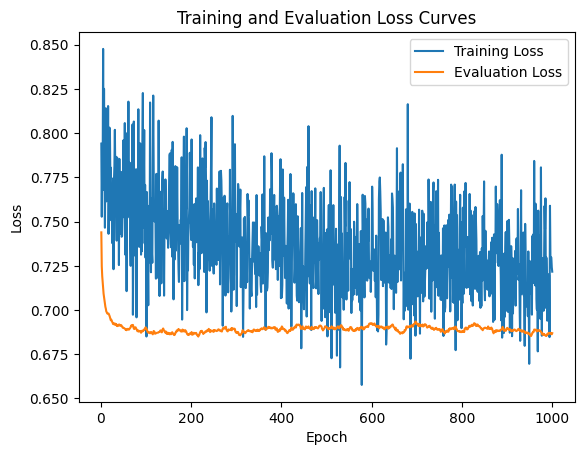

In [71]:
train_recurr_model(np.array(estimated_genes),np.array(recur_labels))

In [72]:
def save_model(model, filename):
    torch.save(model.state_dict(), filename)

save_model(model, 'recurrence_model.pt')